# Additional

In [ ]:
'''from nltk import word_tokenize
def fix_vocab(raw_data):
    vocab = set()
    for tupl in raw_data:
        sen = tupl[0]
        for word in word_tokenize(sen):
            vocab.add(word)
    return vocab
vocab = fix_vocab(raw_data)

def get_grammar_classes(raw_data):
    grammar_classes = {'NN': set(), 'NNS': set(), 'IN': set()}
    for tupl in raw_data:
        print(pos_tag(word_tokenize(tupl[0])))
        for tagged_word in pos_tag(word_tokenize(tupl[0])):
            if tagged_word[1] in grammar_classes.keys():
                grammar_classes[tagged_word[1]].add(tagged_word[0])
    return grammar_classes

    def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('data/train_data_bin_class.txt')
dev_labels, dev_data = read_data('data/dev_data_bin_class.txt')
#test_labels, test_data = read_data('data/dev_data_bin_class.txt')

def hinge_loss(predicted, actual):
    # replacing 0 = -1
    rounded = np.round(predicted)
    new_predicted = np.array([-1 if i==0 else i for i in rounded])
    new_actual = np.array([-1 if i==0 else i for i in actual[0]])
    # calculating hinge loss
    hinge_loss = np.mean([max(0, 1-x*y) for x, y in zip(new_actual, new_predicted[0])])
    return hinge_loss
'''


# Settings

In [99]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [101]:
import numpy as np

BATCH_SIZE = 1
EPOCHS = 20
SEED = 2

# Data Preprocessing

In [82]:
def read_raw_data(filename):
    raw_data = []
    with open(filename) as f:
        for line in f:
            raw_data.append((line[:-2], line[-2]))
    return raw_data
raw_train_data = read_raw_data('data/train_data_bin_class_1.txt')
raw_dev_data = read_raw_data('data/dev_data_bin_class_1.txt')

In [84]:
raw_dev_data

[('seal swims in water ', '3'), ('fox chases after chicken ', '1')]

In [85]:
from lambeq import BobcatParser
parser = BobcatParser(verbose='text')

In [87]:
from collections import defaultdict
from nltk import pos_tag, word_tokenize

grammar_classes = {
    'nouns': ["dog", "cat", "mouse", "fox", "chicken", "grain", "cheese", "bone", "fish", "whale", "seal", "krill", "water", "land"],
    'transitive_verbs': ["chases", "flees", "bites", "eats"],
    'intransitive_verbs': ["barks", "meows", "squeaks", "clucks", "chases", "runs", "swims"],
     'prepositions': ["at", "after", "in", "on"]
}


In [91]:
def create_training_data(raw_data):
    labels, sentences = [], []
    for tupl in raw_data:
        labels.append([1,0])
        sentences.append(tupl[0])
        replaced_token = word_tokenize(tupl[0])[int(tupl[1])]
        for key, value in grammar_classes.items():
            if replaced_token in value:
                for word in value:
                    if word != replaced_token:
                        new_list = word_tokenize(tupl[0])
                        new_list[word_tokenize(tupl[0]).index(replaced_token)] = word
                        new_sen = ' '.join(new_list)
                        labels.append([0,1])
                        sentences.append(new_sen)
    return labels, sentences
training_labels, training_data = create_training_data(raw_train_data)
dev_labels, dev_data = create_training_data(raw_dev_data)

In [106]:
len(training_data)

220

# Circuit Preprocessing

In [92]:
from lambeq import BobcatParser

#parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(training_data)
raw_dev_diagrams = parser.sentences2diagrams(dev_data)
#raw_test_diagrams = parser.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


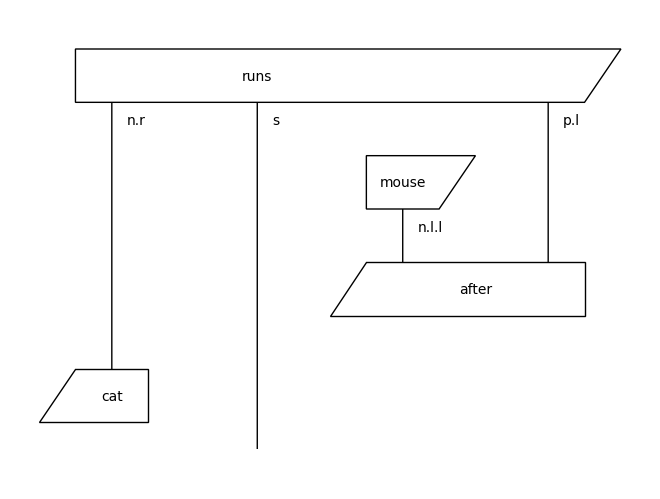

In [93]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
#test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

In [95]:
from lambeq import AtomicType, IQPAnsatz
qubit_map = {t: 1 for t in AtomicType}
ansatz = IQPAnsatz(qubit_map,
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
#test_circuits = [ansatz(diagram) for diagram in test_diagrams]

#train_circuits[1].draw(figsize=(9, 12))

In [96]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits+dev_circuits
                                            #+test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

In [97]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

In [102]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [103]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            training_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [104]:
trainer.fit(train_dataset, val_dataset, logging_step=1)

Epoch 1:   train/loss: 1.6022   valid/loss: 0.9094   train/acc: 0.4727   valid/acc: 0.5000
Epoch 2:   train/loss: 0.9496   valid/loss: 0.7093   train/acc: 0.6182   valid/acc: 0.6042
Epoch 3:   train/loss: 0.8440   valid/loss: 0.6218   train/acc: 0.5818   valid/acc: 0.5833
Epoch 4:   train/loss: 0.7804   valid/loss: 0.6100   train/acc: 0.5932   valid/acc: 0.6667
Epoch 5:   train/loss: 0.7013   valid/loss: 0.5904   train/acc: 0.6568   valid/acc: 0.7083
Epoch 6:   train/loss: 0.6313   valid/loss: 0.5925   train/acc: 0.6841   valid/acc: 0.7500
Epoch 7:   train/loss: 0.5712   valid/loss: 0.5734   train/acc: 0.7136   valid/acc: 0.7917
Epoch 8:   train/loss: 0.5693   valid/loss: 0.5959   train/acc: 0.7023   valid/acc: 0.6667
Epoch 9:   train/loss: 0.6454   valid/loss: 1.2883   train/acc: 0.7114   valid/acc: 0.7500
Epoch 10:  train/loss: 0.6869   valid/loss: 1.6755   train/acc: 0.6864   valid/acc: 0.2917
Epoch 11:  train/loss: 1.1293   valid/loss: 0.7098   train/acc: 0.5591   valid/acc: 0.7083

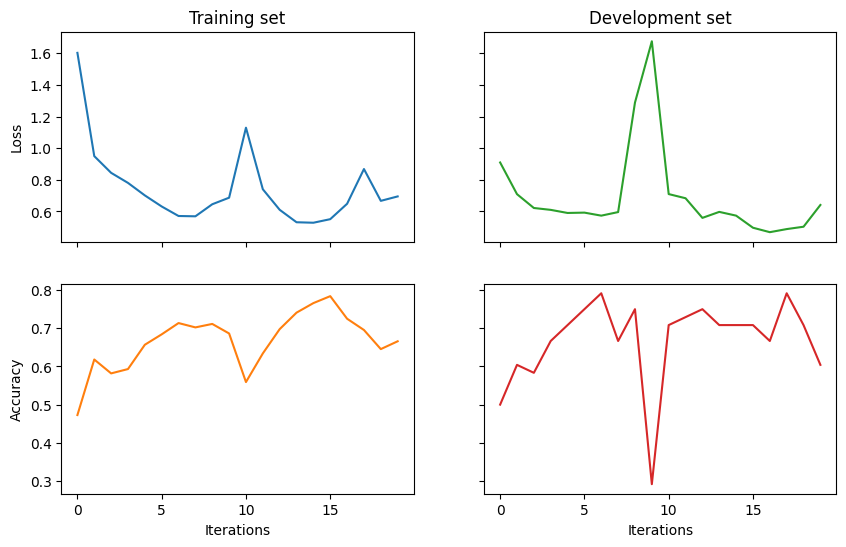

In [105]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))
